In [2]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [10]:
train_data = tf.keras.utils.image_dataset_from_directory('train', batch_size=16, image_size=(150,150))
test_data = tf.keras.utils.image_dataset_from_directory('test', batch_size=16, image_size=(150,150))
valid_data = tf.keras.utils.image_dataset_from_directory('valid', batch_size=16, image_size=(150,150))

Found 84635 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.


In [11]:
train_data = train_data.map(lambda x, y: (x/255, y))
test_data = test_data.map(lambda x, y: (x/255, y))
valid_data = valid_data.map(lambda x, y: (x/255, y))

train_iterator_scaled = train_data.as_numpy_iterator()
test_iterator_scaled = test_data.as_numpy_iterator()
valid_iterator_scaled = valid_data.as_numpy_iterator()


In [12]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=(150, 150, 3))
base_model.trainable = False


In [13]:
model = Sequential()

model.add(base_model)

model.add(tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer"))

model.add(tf.keras.layers.Dense(512, activation="relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Dense(525, activation="softmax"))

In [14]:
model.compile(tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling_laye  (None, 2048)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dense_3 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_190 (Ba  (None, 512)              2048      
 tchNormalization)                                               
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)              

In [15]:
early_stop = tf.keras.callbacks.EarlyStopping(
    patience=3,
    min_delta=0.001,
    restore_best_weights=True,)

In [16]:
history = model.fit(
    train_data,
    epochs=10,
    steps_per_epoch=len(train_data),
    validation_data=valid_data,
    validation_steps=int(0.25 * len(valid_data)),
    callbacks=[early_stop],
)

Epoch 1/10


5290/5290 [==============================] - 356s 67ms/step - loss: 2.7592 - accuracy: 0.3724 - val_loss: 1.3990 - val_accuracy: 0.6280
Epoch 2/10
5290/5290 [==============================] - 401s 76ms/step - loss: 1.9315 - accuracy: 0.5204 - val_loss: 1.1251 - val_accuracy: 0.6982
Epoch 3/10
5290/5290 [==============================] - 246s 46ms/step - loss: 1.7247 - accuracy: 0.5670 - val_loss: 1.1130 - val_accuracy: 0.7180
Epoch 4/10
5290/5290 [==============================] - 245s 46ms/step - loss: 1.6019 - accuracy: 0.5946 - val_loss: 0.9663 - val_accuracy: 0.7393
Epoch 5/10
5290/5290 [==============================] - 245s 46ms/step - loss: 1.5033 - accuracy: 0.6178 - val_loss: 0.9523 - val_accuracy: 0.7470
Epoch 6/10
5290/5290 [==============================] - 245s 46ms/step - loss: 1.4278 - accuracy: 0.6315 - val_loss: 0.9224 - val_accuracy: 0.7607
Epoch 7/10
5290/5290 [==============================] - 246s 46ms/step - loss: 1.3753 - accuracy: 0.6438 - val_loss: 0.9021 - val

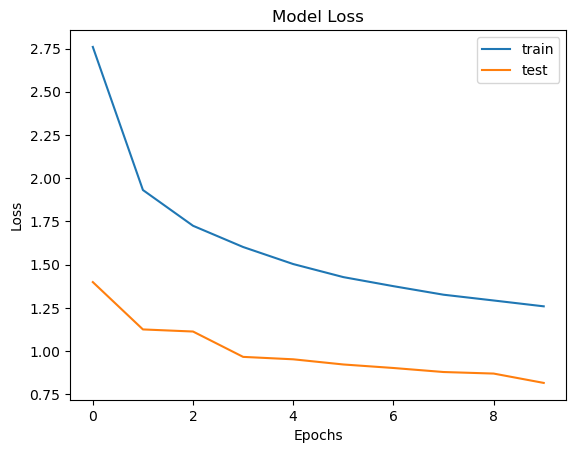

Best Validation Loss: 0.815726
Best Validation Accuracy: 0.791159


In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'])
plt.show()

print(("Best Validation Loss: {:1f}" +\
      "\nBest Validation Accuracy: {:1f}")\
      .format(min(history.history['val_loss']), 
              max(history.history['val_accuracy'])))

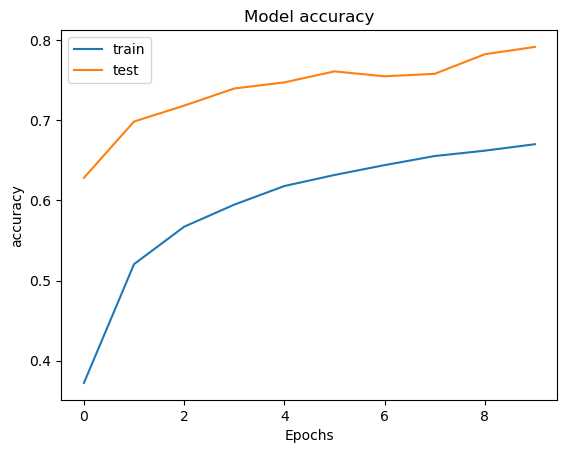

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'test'])
plt.show()

In [31]:
from tensorflow.keras.preprocessing import image
import matplotlib.image as mpimg
import numpy as np

classes = os.listdir('train')
n_classes = len(classes)
print("Total Classes: ",n_classes)


def load_and_preprocess_image(img_path, target_size=(150, 150)):
    img = image.load_img(img_path, target_size=target_size);
    img_array = image.img_to_array(img);
    img_array = np.expand_dims(img_array, axis=0);
    img_array /= 255.0  # Normalize the image
    return img_array

def display_image_and_prediction(model, class_name):
    folder_path = os.path.join('test', class_name);
    
    random_image = np.random.choice(os.listdir(folder_path));
    img_path = os.path.join(folder_path, random_image);

    # Load and preprocess the image
    img_array = load_and_preprocess_image(img_path);

    # Display the image
    img = mpimg.imread(img_path);
    
    # Make a prediction
    prediction = model.predict(img_array);
    predicted_class = np.argmax(prediction);
    predicted_class_name = classes[predicted_class];
    
    if class_name==predicted_class_name: #Paint the title of green if pred is correct and red if it is not
        color='green'
    else:
        color='red'
    
    plt.imshow(img)
    plt.title(f"Real: {class_name} ||| Pred: {predicted_class_name}", color=color)
    plt.axis("off")
    plt.show()

Total Classes:  525


1/1 [==============================] - 0s 25ms/step


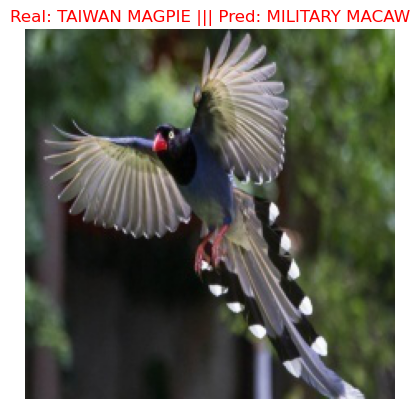

1/1 [==============================] - 0s 19ms/step


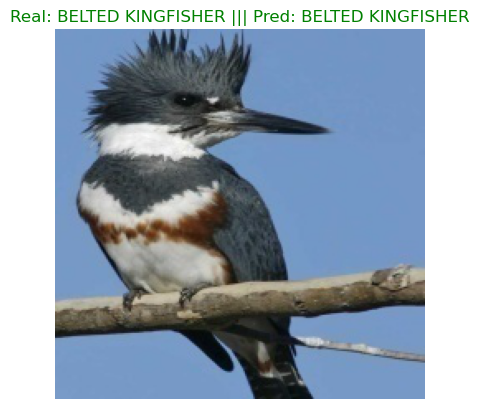

1/1 [==============================] - 0s 22ms/step


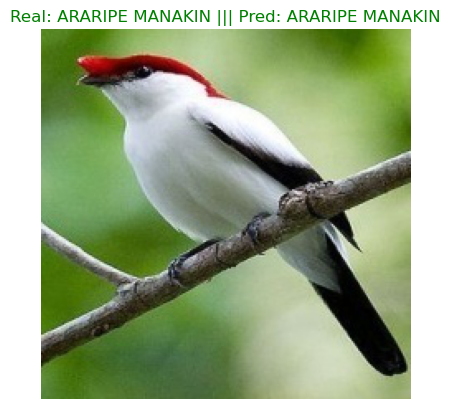

1/1 [==============================] - 0s 17ms/step


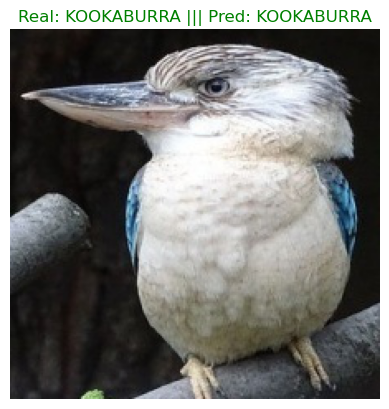

1/1 [==============================] - 0s 24ms/step


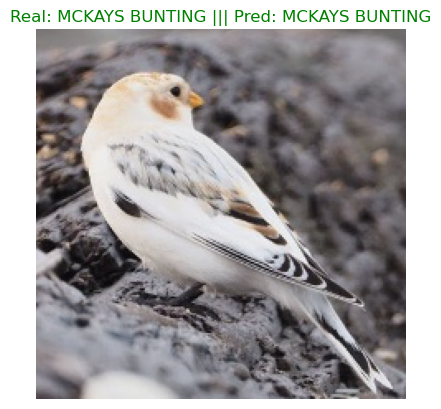

1/1 [==============================] - 0s 22ms/step


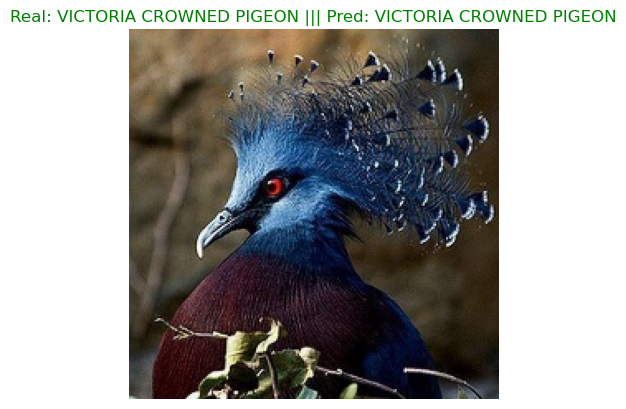

1/1 [==============================] - 0s 10ms/step


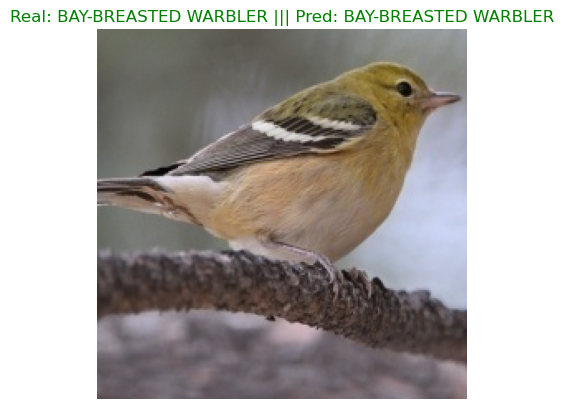

1/1 [==============================] - 0s 17ms/step


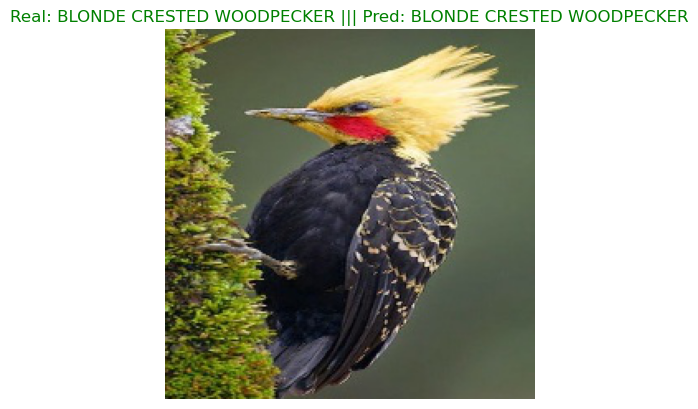

1/1 [==============================] - 0s 26ms/step


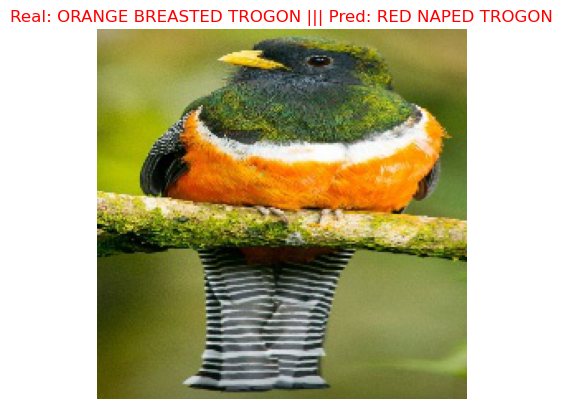

1/1 [==============================] - 0s 19ms/step


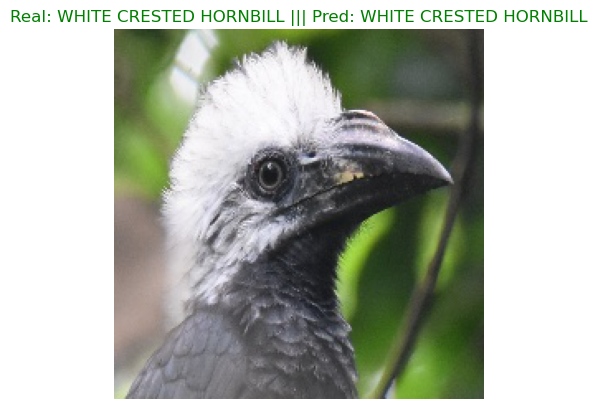

In [36]:
for i in range(10):
        
        display_image_and_prediction(model, classes[np.random.randint(0,n_classes)])